<a href="https://colab.research.google.com/github/alokranjan04/FileSaver.js/blob/master/speech_text_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#path
import os
from os.path import isdir, join
from pathlib import Path

# Scientific Math 
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go

#Deep learning
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

import random
import copy
import librosa

%matplotlib inline

In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_audio_path = '/content/drive/My Drive/text_to_speech/fullTrainData/audio/'

In [0]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs[1:])))
print(dirs)

Number of labels: 30
['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [6]:
all_wav = []
unknown_wav = []
label_all = []
label_value = {}
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknown_list = [d for d in dirs if d not in target_list and d != '_background_noise_' ]
print('target_list : ',end='')
print(target_list)
print('unknowns_list : ', end='')
print(unknown_list)
print('silence : _background_noise_')
i=0;
background = [f for f in os.listdir(join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]
background_noise = []
for wav in background : 
    samples, sample_rate = librosa.load(join(join(train_audio_path,'_background_noise_'),wav))
    samples = librosa.resample(samples, sample_rate, 8000)
    background_noise.append(samples)

for direct in dirs[1:]:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    label_value[direct] = i
    i = i + 1
    print(str(i)+":" +str(direct) + " ", end="")
    for wav in waves:
        samples, sample_rate = librosa.load(join(join(train_audio_path,direct),wav), sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) != 8000 : 
            continue
            
        if direct in unknown_list:
            unknown_wav.append(samples)
        else:
            label_all.append(direct)
            all_wav.append([samples, direct])
            

wav_all = np.reshape(np.delete(all_wav,1,1),(len(all_wav)))
label_all = [i for i in np.delete(all_wav,0,1).tolist()]

#Random pick start point
def get_one_noise(noise_num = 0):
    selected_noise = background_noise[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000)
    return selected_noise[start_idx:(start_idx + 8000)]
  
  
  
max_ratio = 0.1
noised_wav = []
augment = 1
delete_index = []
for i in range(augment):
    new_wav = []
    noise = get_one_noise(i)
    for i, s in enumerate(wav_all):
        if len(s) != 8000:
            delete_index.append(i)
            continue
        s = s + (max_ratio * noise)
        noised_wav.append(s)
np.delete(wav_all, delete_index)
np.delete(label_all, delete_index)  
  
wav_vals = np.array([x for x in wav_all])
label_vals = [x for x in label_all]
wav_vals.shape


labels = copy.deepcopy(label_vals)
for _ in range(augment):
    label_vals = np.concatenate((label_vals, labels), axis = 0)
label_vals = label_vals.reshape(-1,1)


#knowns audio random sampling
unknown = unknown_wav
np.random.shuffle(unknown_wav)
unknown = np.array(unknown)
unknown = unknown[:2000*(augment+1)]
unknown_label = np.array(['unknown' for _ in range(2000*(augment+1))])
unknown_label = unknown_label.reshape(2000*(augment+1),1)



delete_index = []
for i,w in enumerate(unknown):
    if len(w) != 8000:
        delete_index.append(i)
unknown = np.delete(unknown, delete_index, axis=0)



#silence audio
silence_wav = []
num_wav = (2000*(augment+1))//len(background_noise)
for i, _ in enumerate(background_noise):
    for _ in range((2000*(augment+1))//len(background_noise)):
        silence_wav.append(get_one_noise(i))
silence_wav = np.array(silence_wav)
silence_label = np.array(['silence' for _ in range(num_wav*len(background_noise))])
silence_label = silence_label.reshape(-1,1)
silence_wav.shape




wav_vals    = np.reshape(wav_vals,    (-1, 8000))
noised_wav  = np.reshape(noised_wav,  (-1, 8000))
unknown       = np.reshape(unknown,   (-1, 8000))
silence_wav = np.reshape(silence_wav, (-1, 8000))


print(wav_vals.shape)
print(noised_wav.shape)
print(unknown.shape)
print(silence_wav.shape)



print(label_vals.shape)
print(unknown_label.shape)
print(silence_label.shape)



wav_vals = np.concatenate((wav_vals, noised_wav), axis = 0)
wav_vals = np.concatenate((wav_vals, unknown), axis = 0)
wav_vals = np.concatenate((wav_vals, silence_wav), axis = 0)

label_vals = np.concatenate((label_vals, unknown_label), axis = 0)
label_vals = np.concatenate((label_vals, silence_label), axis = 0)



train_wav, test_wav, train_label, test_label = train_test_split(wav_vals, label_vals, 
                                                                    test_size=0.2,
                                                                    random_state = 1993,
                                                                   shuffle=True)


# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 512
drop_out_rate = 0.5
input_shape = (8000,1)



print(len(wav_vals))
print(len(label_vals))



#For Conv1D add Channel
train_wav = train_wav.reshape(-1,8000,1)
test_wav = test_wav.reshape(-1,8000,1)



label_value = target_list
label_value.append('unknown')
label_value.append('silence')



new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value



#Make Label data 'string' -> 'class num'
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

#Make Label data 'class num' -> 'One hot vector'
train_label = keras.utils.to_categorical(train_label, len(label_value))
test_label = keras.utils.to_categorical(test_label, len(label_value))



print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))


#Conv1D Model
input_tensor = Input(shape=(input_shape))

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(len(label_value), activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])


model.summary()


history = model.fit(train_wav, train_label, validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=100,
          verbose=1)

target_list : ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknowns_list : ['bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero']
silence : _background_noise_
1:bed 2:bird 3:cat 4:dog 5:down 6:eight 7:five 8:four 9:go 10:happy 11:house 12:left 13:marvin 14:nine 15:no 16:off 17:on 18:one 19:right 20:seven 21:sheila 22:six 23:stop 24:three 25:tree 26:two 27:up 28:wow 29:yes 30:zero (21343, 8000)
(21343, 8000)
(4000, 8000)
(3996, 8000)
(42686, 1)
(4000, 1)
(3996, 1)
50682
50682
Train_Wav Demension : (40545, 8000, 1)
Train_Label Demension : (40545, 12)
Test_Wav Demension : (10137, 8000, 1)
Test_Label Demension : (10137, 12)
Number Of Labels : 12
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
____________________________

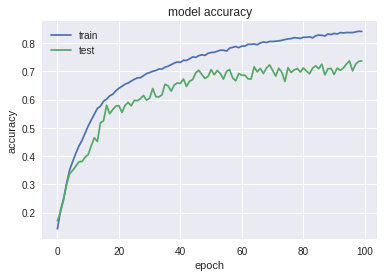

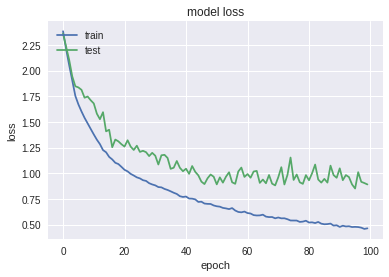

In [7]:

import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
29s 712us/step - loss: 0.8733 - acc: 0.6989 - val_loss: 0.9194 - val_acc: 0.6855